In [1]:
from os.path import exists 
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


task = "cyp2c9"

# Data

In [2]:
data = data_preprocessing(task)
# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp2c9/raw_dataset.csv.
Numbe of molecules before druglikeliness selection: 12092
Numbe of druglike molecules: 11639


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
1,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
2,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
4,0,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,645164.0,13.082813,-0.044883,13.082813,0.018472,0.457249,495.628,458.332,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12087,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12088,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12089,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12090,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data = data.drop(data_nan.index)
print("Data shape after dropping NaN samples:", data.shape)
data_nan

There are 41 (0.35%) molecules and 12 descriptors with missing values.
Data shape after dropping NaN samples: (11598, 2260)


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3682,O=[N+]([O-])c1ccc(C[As](=O)(O)O)cc1,222574.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3708,C[C@@H](O)COc1ccc([As](=O)(O)O)cc1N,3246035.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3718,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3719,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3720,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3721,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3722,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3723,O=[As]c1ccc(S(=O)(=O)NCCO)cc1,224336.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3728,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3743,O=[As](O)(O)c1ccc(N=Nc2ccc([As](=O)(O)O)cc2)cc1,23749.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train-Validation-Test split


In [4]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


In [ ]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)
datasets["train"].describe()

# Training

Use ```utils/training/BayesianOptimizer```. To do random search simply set ```n_calls=n_initial_points``` in ```self.optimize()```.

## Dummy Classifier

In [ ]:
get_baseline(datasets)

## SVC

In [ ]:
svc_0 = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    fix_model_params={"class_weight": "balanced"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc"
)

svc_0.optimize(n_calls=20) 
svc_0.pretty_results()

In [ ]:
metric_columns = list(svc_0.results.filter(regex='val_'))
# Position 0
best_params_0 = svc_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
svc_0_y_pred, svc_0_y_pred_proba = svc_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], svc_0_y_pred, svc_0.file_loc)

del svc_0

## RandomForestClassifier

For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale invariant and has inbuild feature selection.

In [5]:
x_train = datasets["train"].drop("Y", axis=1)
y_train = datasets["train"]["Y"]
x_val = datasets["val"].drop("Y", axis=1)
y_val = datasets["val"]["Y"]

# drop constant features
preprocessing_pipe = DataPreprocessing(feature_groups, corr_threshold=1.0)
preprocessing_pipe.fit(x_train, y_train)
x_train_preprocessed = preprocessing_pipe.transform(x_train)
x_val_preprocessed = preprocessing_pipe.transform(x_val)

rf_max_depth = train_random_forest_depth(
    f"optimization/{task}/rf_max_depth",
    x_train_preprocessed,
    x_val_preprocessed,
    y_train,
    y_val,
    class_weight="balanced"
)

metric_columns = list(rf_max_depth.filter(regex="val_"))

pretty_print_df(
    rf_max_depth.sort_values("val_mcc", ascending=False), subset=metric_columns, quantile=0.98
)

,max_depth,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
12,15,0.823276,0.742138,0.726601,0.758355,0.608127,0.872539,0.762683
44,47,0.828448,0.732167,0.768362,0.699229,0.607848,0.879031,0.777699
13,16,0.824138,0.739796,0.734177,0.745501,0.607036,0.872202,0.764978
43,46,0.825000,0.728972,0.758333,0.701799,0.601023,0.880069,0.781868
49,52,0.825000,0.726046,0.764205,0.691517,0.599566,0.881771,0.774013


In [6]:
best_depth = int(rf_max_depth.sort_values("val_mcc", ascending=False).iloc[0]["max_depth"])
best_rf = RandomForestClassifier(max_depth = best_depth, class_weight="balanced", n_jobs=-1)
best_rf.fit(x_train_preprocessed, y_train)
rf_best_y_pred = best_rf.predict(x_val_preprocessed)
rf_best_y_pred_proba = best_rf.predict_proba(x_val_preprocessed)[:,1]

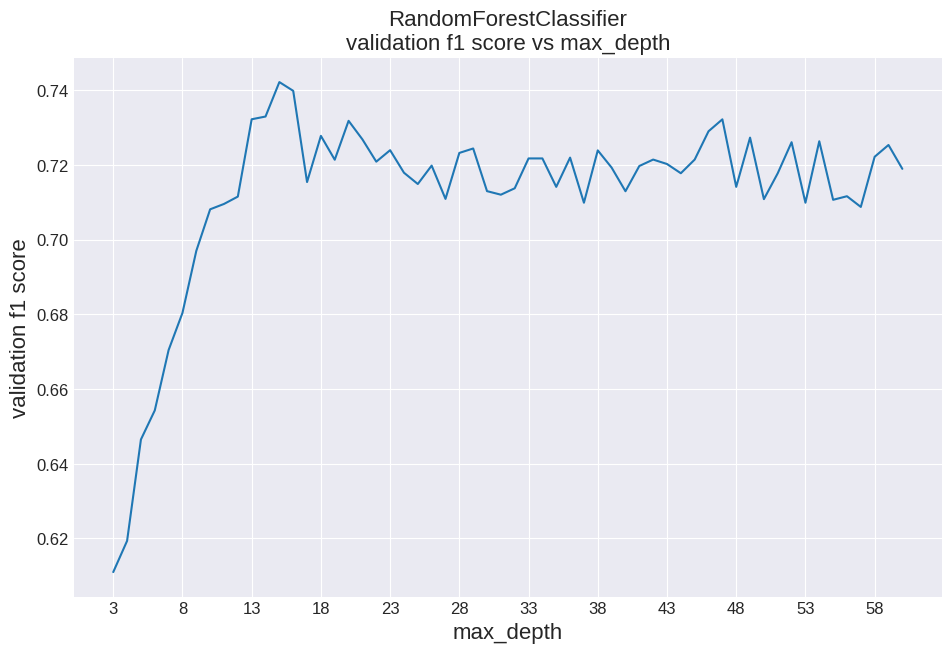

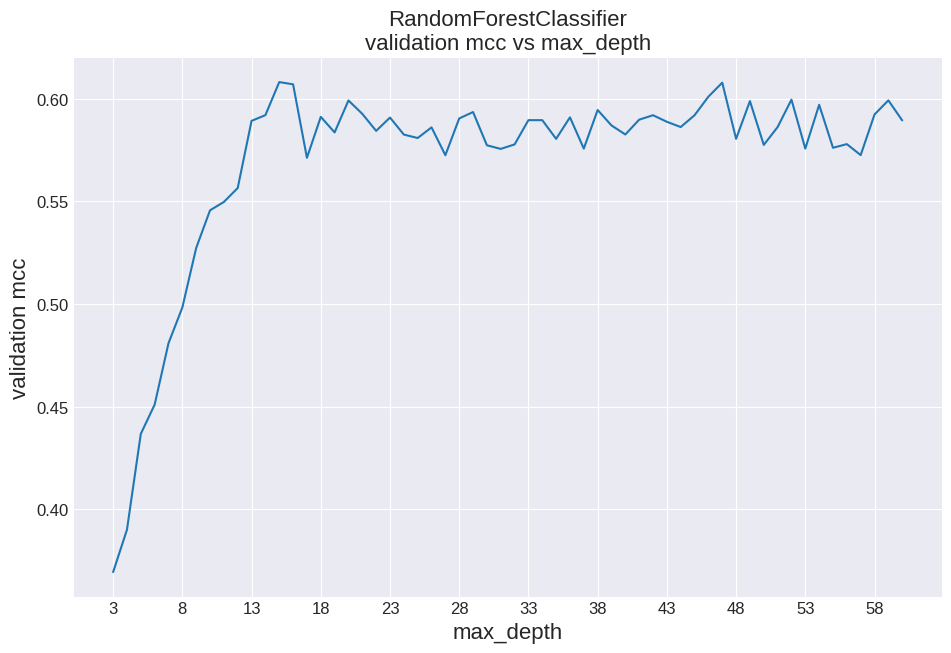

In [7]:
plot_parameter_metric(
    metric_values=rf_max_depth["val_f1"],
    model_name="RandomForestClassifier",
    metric="validation f1 score",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

plot_parameter_metric(
    metric_values=rf_max_depth["val_mcc"],
    model_name="RandomForestClassifier",
    metric="validation mcc",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

Accuracy: 81.55%
F1-score: 73.12%
Matthews correlation coefficient: 0.5911953150899925%


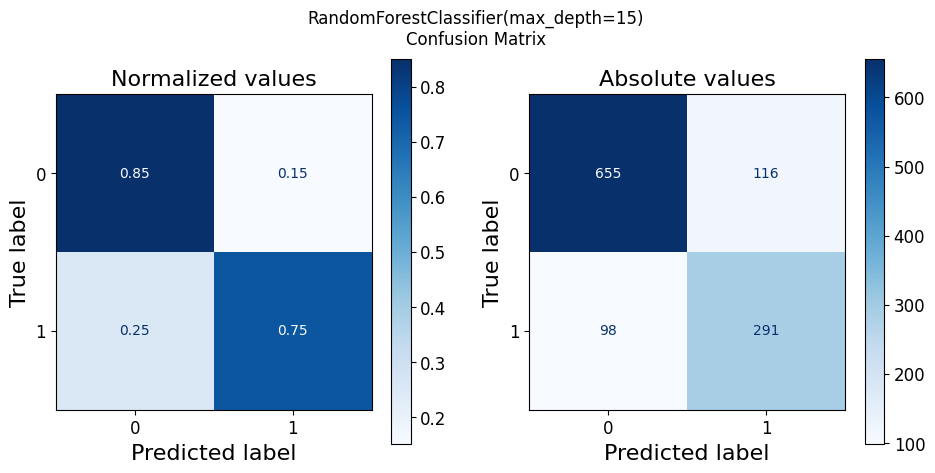

In [8]:
conf_matrix(y_val, rf_best_y_pred, f"RandomForestClassifier(max_depth={best_depth})")

In [ ]:
compare_metric_curves(
    {
        "RandomForestClassifier": rf_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Logistic Regression

In [ ]:
lr_0 = BayesianOptimization(
    model=LogisticRegression,
    file_name=f"{task}/lr_0",
    model_params=[
        Real(name="C", low=0.1, high=4.0),
        Real(name="l1_ratio", low=0, high=1),
    ],
    fix_model_params={
        "solver": "saga",
        "n_jobs": -1,
        "class_weight": "balanced",
        "penalty": "elasticnet",
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

lr_0.optimize(n_calls=20)
lr_0.pretty_results()

In [ ]:
metric_columns = list(lr_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = lr_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
lr_0_best_y_pred, lr_0_best_y_pred_proba = lr_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], lr_0_best_y_pred, lr_0.file_loc)

del lr_0 

## CatBoost


In [ ]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

catboost_0 = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_0",
    model_params=[
        Integer(name="max_depth", low=4, high=12),
        Real(name="l2_leaf_reg", low=2., high=10.),
        # Categorical(name="boosting_type", categories=["Ordered", "Plain"]),
        Real(name="scale_pos_weight",low=max(1,n_negative/n_positive-1), high=6),
    ],
    fix_model_params={
        "verbose": 0,
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

catboost_0.optimize(n_calls=50)
catboost_0.pretty_results(quantile=0.9)

In [ ]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

In [ ]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[4]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

del catboost_0

## KNN

In [ ]:
knn_0 = BayesianOptimization(
    model=KNeighborsClassifier,
    file_name=f"{task}/knn_0", 
    model_params=[
        Integer(name="n_neighbors", low=3, high=60),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None,
    main_metric="mcc",
    fix_model_params={"weights":"distance"}
)

knn_0.optimize(n_calls=20)
knn_0.pretty_results()

In [ ]:
metric_columns = list(knn_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)

best_params_0 = list(knn_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
knn_0_best_y_pred, knn_0_best_y_pred_proba = knn_0.get_predictions(best_params_0)
conf_matrix(datasets["val"]["Y"], knn_0_best_y_pred, knn_0.file_loc)

del knn_0

## XGBoost

In [ ]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

xgboost_0 = BayesianOptimization(
    model=XGBClassifier,
    file_name=f"{task}/xgboost_0",
    model_params=[
        Integer(name="max_depth", low=5, high=50),
        Real(name="eta", low=0.01, high=0.2),
        Real(name="subsample", low=0.5, high=1),
        Real(name="scale_pos_weight", low=max(1, n_negative / n_positive - 1), high=6),
        Real(name="colsample_bytree", low=0.5, high=1.0),
        Real(name="lambda", low=0.5, high=4.0),
    ],
    fix_model_params={"objective": "binary:logistic", "eval_metric": "aucpr"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

xgboost_0.optimize(n_calls=50)
xgboost_0.pretty_results()

In [ ]:
metric_columns = list(xgboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = list(xgboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
xgboost_0_best_y_pred, xgboost_0_best_y_pred_proba = xgboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], xgboost_0_best_y_pred, xgboost_0.file_loc)


In [ ]:
compare_metric_curves(
    {
        "XGBoost" : xgboost_0_best_y_pred_proba
    },
    datasets["val"]["Y"],
)